# Eric's Incredible* Thesis Project
_*incredibly mediocre_

In [2]:
import pandas as pd
import numpy as np
import sys, os
import pickle, sqlite3
import datetime

import findata_utils as fd

import matplotlib.pyplot as plt
from matplotlib import rcParams

# Connect to databases
db = 'C:\\Datasets\\thesis.db'
conn = sqlite3.connect(db)
c = conn.cursor()

In [3]:
threefactor = fd.get_french('North_America_3_Factors_Daily')
for column in threefactor.columns[1:]:
    threefactor[column] = threefactor[column]*0.01
threefactor['Rm'] = threefactor['Mkt-RF']+threefactor['RF']
threefactor['date'] = threefactor['Date'].apply(lambda Date: datetime.datetime.strptime(str(Date),'%Y%m%d'))
threefactor['CulmRm'] = (threefactor['Rm']+1).cumprod()

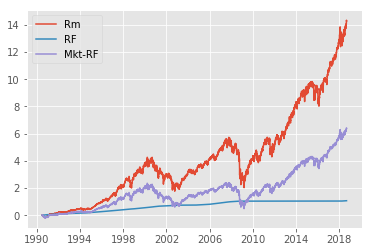

In [4]:
#plt.plot(threefactor['date'],threefactor['Rm'])
#plt.plot(threefactor['date'],threefactor['Mkt-RF'])
#plt.plot(threefactor['date'],threefactor['RF'])
plt.style.use('ggplot')
plt.plot(threefactor['date'],((threefactor['Rm']+1).cumprod()-1))
plt.plot(threefactor['date'],((threefactor['RF']+1).cumprod()-1))
plt.plot(threefactor['date'],((threefactor['Mkt-RF']+1).cumprod()-1))
plt.legend(['Rm','RF','Mkt-RF'])
plt.show()

## Load everything into memory

In [5]:
# Query the database for close price data
px = pd.read_sql('''
    SELECT date,ticker, MAX(c) AS c
    FROM cfmrc
    WHERE ticker IN
        (SELECT ticker FROM indexchanges) 
    GROUP BY ticker,date'''
    ,conn).drop_duplicates()

# Query the database for close price data
allpx = pd.read_sql('''
    SELECT date,ticker, MAX(c) AS c
    FROM cfmrc
    GROUP BY ticker,date'''
    ,conn).drop_duplicates()

print('Obtained %d close prices' % len(px.index))

rebal_day = pd.read_sql('''
    SELECT s.date, s.ticker, c AS rebalpx, flag
    FROM cfmrc s
    INNER JOIN indexchanges i
    WHERE s.date=i.date 
        AND s.ticker=i.ticker'''
    ,conn)

print('Obtained rebalance day price info for %d securities' % len(rebal_day.index))

Obtained 277212 close prices
Obtained rebalance day price info for 178 securities


## Try to calculate rates of return on adds/deletes

In [97]:
# Merge rebalance data to price data
df = px.merge(rebal_day, on=['ticker'])
df.columns = ['date','ticker','px','rebal','rebalpx','flag']

df['flag'] = df['flag'].apply(lambda flag: 1 if flag==1 else -1)

# Compute price deltas
df['delta'] = (df['px']-df['rebalpx'])*df['flag']
df['return'] = df['delta']/df['rebalpx']

# Parce dates
df['date'] = df['date'].apply(lambda date: datetime.datetime.strptime(date,'%Y-%m-%d'))
df['rebal'] = df['rebal'].apply(lambda date: datetime.datetime.strptime(date,'%Y-%m-%d'))

# Days unitl rebal
df['d'] = df['date']-df['rebal']
df['d'] = df['d'].apply(lambda d: d.days)

df = df.merge(threefactor[['Rm','CulmRm','date']], on=['date'])

print(df.head())

        date  ticker     px      rebal  rebalpx  flag  delta    return     d  \
0 2012-09-19  AAR.UN   4.97 2015-03-20     5.01     1  -0.04 -0.007984  -912   
1 2012-09-19    AC.B   1.23 2013-09-20     3.30     1  -2.07 -0.627273  -366   
2 2012-09-19     ACQ  12.30 2014-06-20    85.98     1 -73.68 -0.856943  -639   
3 2012-09-19     ACQ  12.30 2016-03-18    18.00    -1   5.70  0.316667 -1276   
4 2012-09-19      AD  23.64 2013-09-20    35.20     1 -11.56 -0.328409  -366   

       Rm    CulmRm  
0  0.0016  7.142968  
1  0.0016  7.142968  
2  0.0016  7.142968  
3  0.0016  7.142968  
4  0.0016  7.142968  


In [98]:
adjustments = df[df['d']==0][['ticker','CulmRm']]
adjustments.columns = ['ticker','CulmRmAtT0']
df = df.merge(adjustments, on=['ticker'])
df['IndRm'] = (df['CulmRm']/df['CulmRmAtT0'])-1

m = df[['d','IndRm']].groupby(by='d').mean().reset_index()
s = df[['d','IndRm']].groupby(by='d').std().reset_index()
Rm = m.merge(s, on='d', suffixes=('Avg','SD'))
print(Rm.head())

      d  IndRmAvg   IndRmSD
0 -3084 -0.570013  0.095982
1 -3083 -0.568680  0.096279
2 -3082 -0.567688  0.096501
3 -3081 -0.566434  0.096781
4 -3080 -0.564570  0.097197


### Investigate stock-specific abnormal returns

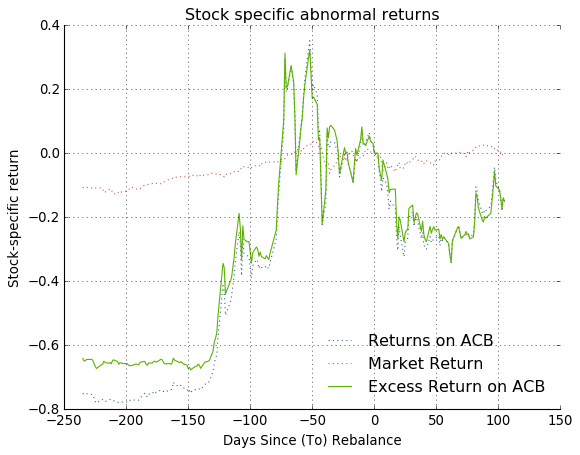

In [104]:
ticker = 'ACB'
stock_df = df[(df['ticker']==ticker) & (abs(df['d'])<=365)]

plt.style.use('classic')
#daily = df[['ticker','d','return']].drop_duplicates()
#daily = pd.pivot_table(daily, index='d',columns='ticker',values='return', aggfunc=np.max).reset_index()

#daily['avg'] = daily.drop('d',axis=1).mean(axis=1)
#daily['std'] = daily.drop('d',axis=1).std(axis=1)

fig = plt.figure()
fig.patch.set_facecolor('white')

ax = fig.add_subplot(1, 1, 1)

ax.spines['left'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.grid(True,axis='both',linestyle=':')

ax.plot(stock_df['d'],stock_df['return'], color='xkcd:denim',linestyle=':')
ax.plot(stock_df['d'],stock_df['IndRm'], color='xkcd:dark salmon',linestyle=':')
ax.plot(stock_df['d'],stock_df['return']-stock_df['IndRm'], color='xkcd:kermit green',linestyle='-')

#ax.fill_between(daily['d'], daily['avg']-daily['std'], daily['avg']+daily['std'], color="#3b638c", alpha=0.1)
#ax.fill_between(daily['d'], Rm['IndRmAvg']-Rm['IndRmSD'], Rm['IndRmAvg']+Rm['IndRmSD'], color="#c85a53", alpha=0.1)

ax.legend(['Returns on %s'%ticker,'Market Return','Excess Return on %s'%ticker], frameon=False, loc='best')

plt.ylabel('Stock-specific return')
plt.xlabel('Days Since (To) Rebalance')
plt.title('Stock specific abnormal returns')

#plt.xlim(-91,91)
#plt.ylim(-1,1)
plt.show()

plt.show()

### What if you just rolled the dice and hoped for the best?

### Investigate portfolio-wide abnormal returns

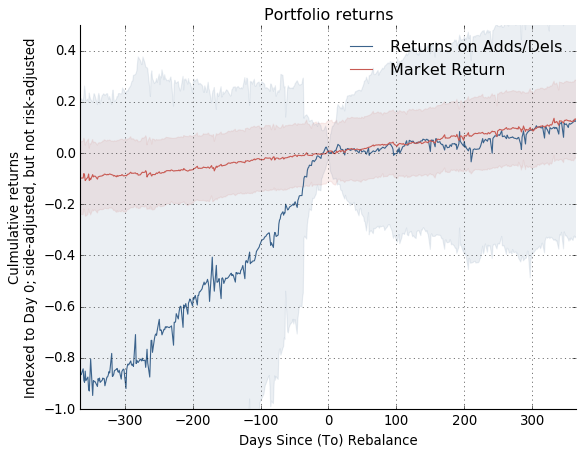

ticker  d    AAR.UN      AC.B       ACB       ACQ        AD     AGF.B  \
2198   -4 -0.011976  0.039394  0.063927  0.006048  0.018182  0.047198   
2199   -3 -0.003992  0.039394  0.041096  0.044545  0.021307  0.039823   
2200   -2  0.003992 -0.006061  0.031963  0.028146 -0.000284  0.042773   
2201   -1 -0.003992 -0.006061  0.027397  0.010351  0.011648  0.038348   
2202    0  0.000000  0.000000  0.000000  0.000000  0.000000 -0.000000   
2203    3  0.003992  0.009091 -0.013699  0.055556 -0.007670 -0.008850   
2204    4  0.007984  0.066667 -0.059361  0.048333 -0.006818  0.010324   
2205    5  0.017964  0.121212 -0.079452  0.082222  0.001989  0.057522   
2206    6  0.015968  0.121212 -0.120548  0.032222 -0.011648  0.091445   
2207    7 -0.003992  0.096970 -0.076712 -0.073157  0.026989  0.085546   

ticker       AIF       AIM       AKG    ...          UNS       VII       WCP  \
2198    0.033522 -0.257669  0.055866    ...     0.011605  0.045625  0.057609   
2199    0.021524 -0.282209  0.014898

In [102]:
plt.style.use('classic')
daily = df[['ticker','d','return']].drop_duplicates()
daily = pd.pivot_table(daily, index='d',columns='ticker',values='return', aggfunc=np.max).reset_index()

daily['avg'] = daily.drop('d',axis=1).mean(axis=1)
daily['std'] = daily.drop('d',axis=1).std(axis=1)

fig = plt.figure()
fig.patch.set_facecolor('white')

ax = fig.add_subplot(1, 1, 1)

ax.spines['left'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.grid(True,axis='both',linestyle=':')

ax.plot(daily['d'],daily['avg'], color='#3b638c')
ax.plot(daily['d'],Rm['IndRmAvg'], color='#c85a53')

ax.fill_between(daily['d'], daily['avg']-daily['std'], daily['avg']+daily['std'], color="#3b638c", alpha=0.1)
ax.fill_between(daily['d'], Rm['IndRmAvg']-Rm['IndRmSD'], Rm['IndRmAvg']+Rm['IndRmSD'], color="#c85a53", alpha=0.1)

ax.legend(['Returns on Adds/Dels','Market Return'], frameon=False, loc='best')

plt.title('Portfolio returns')
plt.ylabel('Culmulative returns\nIndexed to Day 0; side-adjusted, but not risk-adjusted')
plt.xlabel('Days Since (To) Rebalance')
plt.xlim(-365,365)
plt.ylim(-1,.5)
plt.show()

print(daily[(daily['d']>-5) & (daily['d']<8)])

In [ ]:
all_returns = []
for i,j in daily.iterrows():
    all_returns.extend(j.drop(['d','avg']).dropna().values)
plt.hist(all_returns)
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.title('Distribution of Returns\n(u=%d%%, s=%d%%)' % (np.mean(all_returns)*100,np.std(all_returns)*100))
plt.show()

# Risk Adjust the Returns

In [ ]:
cormat = pd.pivot_table(allpx, index='date',columns=['ticker'], values=['c']).pct_change().corr().reset_index()
cormat.columns = cormat.columns.get_level_values(1)
cormat.drop(cormat.columns[0],axis=1, inplace=True)

In [ ]:
matched_tickers = pd.Series(name='Matched')
for ticker in daily.columns[1:-2]:
    match = cormat[[ticker]].sort_values(by=ticker).index[0]
    matched_ticker = cormat.columns[match]
    matched_tickers[ticker] = matched_ticker
    
    comp = allpx[allpx['ticker']==matched_tickers['AAR.UN']]g
    
print(matched_tickers.head())

# Clean up the environment

In [3]:
c.close()